Importing required libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

Loading Data

In [3]:
df_train = pd.read_csv("netflix_titles.csv")
df_train.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


Check any null value and the shape

In [4]:
df_train.isnull().values.any()
df_train.shape

(6234, 12)

In [5]:
from io import StringIO

col = ['type', 'description']
df_train = df_train[col]
df_train = df_train[pd.notnull(df_train['description'])]
df_train.columns = ['type', 'description']

df_train['category_id'] = df_train['type'].factorize()[0]

category_id_df_train = df_train[['type', 'category_id']].drop_duplicates().sort_values('category_id')

category_to_id = dict(category_id_df_train.values)

id_to_category = dict(category_id_df_train[['category_id', 'type']].values)

df_train.head()

,type,description,category_id
0,Movie,Before planning an awesome wedding for his gra...,0
1,Movie,Jandino Asporaat riffs on the challenges of ra...,0
2,TV Show,"With the help of three human allies, the Autob...",1
3,TV Show,When a prison ship crash unleashes hundreds of...,1
4,Movie,When nerdy high schooler Dani finally attracts...,0


In [6]:
df_train['description'][7]

'Fabrizio Copano takes audience participation to the next level in this stand-up set while reflecting on sperm banks, family WhatsApp groups and more.'

See the distribution of Movie and TV Show sentiments in our dataset

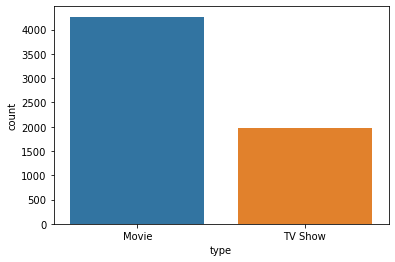

In [7]:
import seaborn as sns

sns.countplot(x='type', data=df_train)

Data Preprocessing

In [8]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [9]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

We will preprocess our reviews

In [10]:
X = []
sentences = list(df_train['description'])
for sen in sentences:
    X.append(preprocess_text(sen))

The seventh review

In [11]:
X[7]

'Fabrizio Copano takes audience participation to the next level in this stand up set while reflecting on sperm banks family WhatsApp groups and more '

We only have two labels in the output i.e. "Movie" and "TV Show"

In [12]:
y = df_train['category_id']

 Use train_test_split method

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Preparing the Embedding Layer

In [14]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Adding 1 because of reserved 0 index

In [15]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Use GloVe embeddings to create our feature matrix

In [16]:
from numpy import array
from numpy import asarray
from numpy import zeros

In [17]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

Create an embedding matrix

In [18]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Text Classification with Simple Neural Network

In [19]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

Use adam optimizer

In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1449400   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 10001     
Total params: 1,459,401
Trainable params: 10,001
Non-trainable params: 1,449,400
_________________________________________________________________
None


Fit method to train neural network

In [21]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
32/32 [==============================] - 0s 13ms/step - loss: 0.6507 - acc: 0.6558 - val_loss: 0.6234 - val_acc: 0.6774
Epoch 2/6
32/32 [==============================] - 0s 6ms/step - loss: 0.5810 - acc: 0.7009 - val_loss: 0.6075 - val_acc: 0.6814
Epoch 3/6
32/32 [==============================] - 0s 7ms/step - loss: 0.5562 - acc: 0.7207 - val_loss: 0.6042 - val_acc: 0.6834
Epoch 4/6
32/32 [==============================] - 0s 6ms/step - loss: 0.5296 - acc: 0.7471 - val_loss: 0.6037 - val_acc: 0.6884
Epoch 5/6
32/32 [==============================] - 0s 7ms/step - loss: 0.5107 - acc: 0.7628 - val_loss: 0.6054 - val_acc: 0.6794
Epoch 6/6
32/32 [==============================] - 0s 7ms/step - loss: 0.4975 - acc: 0.7716 - val_loss: 0.6132 - val_acc: 0.6804


Evaluate method

In [22]:
score = model.evaluate(X_test, y_test, verbose=1)

39/39 [==============================] - 0s 2ms/step - loss: 0.6078 - acc: 0.6840


Check test accuracy and loss

In [23]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6077635288238525
Test Accuracy: 0.6840416789054871


Plot the accuracy and loss differences for training and test sets

In [24]:
import matplotlib.pyplot as plt

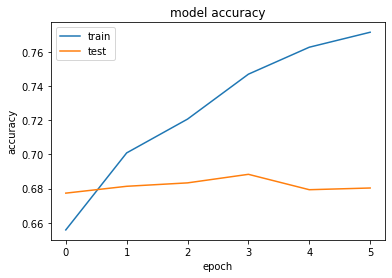

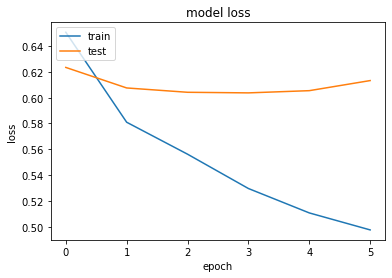

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])


plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

